In [37]:
#load relevant libraries
import pandas as pd
from pandas import DataFrame 
from pandas import Series
import json,csv
#import delorean
import matplotlib.pyplot as plt
#this allows your graphs to show up in the nb, super important
%matplotlib inline 
import datetime
from datetime import datetime
import matplotlib.dates as mdates
from collections import defaultdict 
import numpy as np
import math

#import this to make network graphs
import networkx as nx
#helps you make prettier graphs
import seaborn as sns 

In [3]:
#open data file
infilename = "events-feb-4-two-plays.json"
infile = open(infilename,'rb')
#read each line of json 
mydata = []
for line in infile:
    mydata.append(json.loads(line))

#make a dataframe from the data
myData = DataFrame(mydata)

In [4]:
#make a dictionary for all the group names
groupDict = {
    0.0: 'white-group',
    1.0: 'red-group',
    2.0: 'green-group',
    3.0: 'pink-group',
    4.0: 'blue-group',
    5.0: 'yellow-group',
    6.0: 'orange-group',
    7.0: 'turquoise-group',
    8.0: 'fuschia-group'
}

In [9]:
#some functions
#function to convert list of epoch times in milliseconds to a list of python datetimes
def convertTime(timeList):
    for i in range(len(timeList)):
        tempTime= datetime.fromtimestamp(timeList[i]/1000)
        timeList[i]=tempTime 
    return timeList;

#function to grab timestamp for when a year started
#this function does not handle the first year of the game; need to add to it!
def getYearStart(myYear, myData, myGame):
    dfGame = myData.loc[myData.gameCode==myGame]
    dfYears = dfGame.loc[myData.key=='GameYearIncrease']
    dfMyYear = dfYears.loc[dfYears.newYearValue==myYear]
    if len(dfMyYear)==0:
        return -1 #returns -1 if year is not in the game
    else:
        return dfMyYear.iloc[0]['timestamp']

In [6]:
#write a function that will return a running total of cash that will be reset each year
#function will take in a group id and df of all data and string of the game code, and return a df with time and cash total
def runningCash(groupId, myData, myGame):
    dfCash = myData[(myData.key=='CashingOutResource')&(myData.gameCode==myGame)]
    dfYear = myData[(myData.key=='GameYearIncrease')&(myData.gameCode==myGame)]
    #first filter for cashout events of this group
    df = dfCash.loc[dfCash.group==groupId]
    #make empty lists;will combine them into a df later
    cash = list()
    time = list()
    year = list()

    #get initial year, initial cash total, and add entries to all the lists
    curTime = df.iloc[0]['timestamp']
    pastYear = df.iloc[0]['year']
    cashTotal = df.iloc[0]['cash']
    cash.append(cashTotal)
    time.append(curTime)
    year.append(pastYear)
    
    #now loop through all the other cash outs
    for i in range(1,len(df)):
        curTime = df.iloc[i]['timestamp']
        curYear = df.iloc[i]['year']
        #print i
        #print curTime
        #print datetime.fromtimestamp(curTime/1000)
        #print curYear
        #print '------'
        #if the year is the same, then just add cash to the total and add entries to all lists
        if curYear == pastYear:
            cashTotal = cashTotal + df.iloc[i]['cash']
            cash.append(cashTotal)
            time.append(curTime)
            year.append(curYear)
            
            #added this code to handle last entry;
            if i==len(df)-1 and curYear<max(dfYear['newYearValue']):
                nextYearStart = getYearStart(curYear+1,myData,myGame)
                tempTime = nextYearStart - 10
                cash.append(cashTotal)
                time.append(tempTime)
                year.append(pastYear)
                
        #if year is different, then set the total cash = to the cash for this entry, and add entries to lists
        if pastYear+1==curYear:
            #this section of codes adds an entry just before the year changes so that the cash plateaus
            #to get rid of the plateaus, comment out the next 6 lines
            prevCashTotal = cashTotal
            curYearStart = getYearStart(curYear,myData,myGame)
            tempTime = curYearStart - 10
            cash.append(prevCashTotal)
            time.append(tempTime)
            year.append(pastYear)

            #now add entry for the new cash total for the new year
            cashTotal = df.iloc[i]['cash']
            cash.append(cashTotal)
            time.append(curTime)
            year.append(curYear)
        #set the pastYear equal to the current year to prepare for next iteration
        pastYear = curYear
    
    #we know that cash is zero'ed each new year, so we can also add entries for these zero'ing events
    for j in range(len(dfYear)):
        cash.append(0)
        time.append(dfYear.iloc[j]['timestamp'])
        year.append(dfYear.iloc[j]['newYearValue'])

    #now make a data frame with these cols
    newDF = pd.DataFrame(
    {'cashTotal': cash,
     'timestamp': time,
     'datetime': convertTime(time),
     'year': year
    })

    #reorder data by timestamp
    return newDF


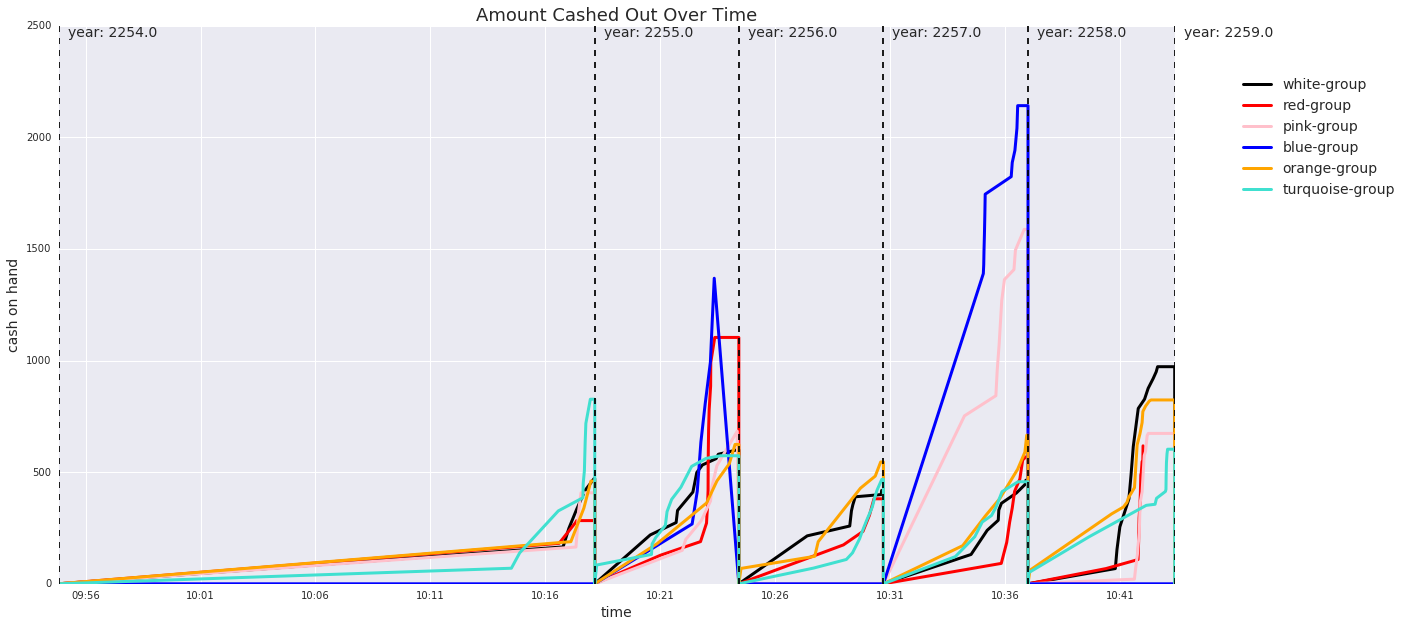

In [12]:
#this code will make a plot of cashouts for all groups in a given game, using the function runningCash 
myGame = '2416'
dfYear = myData[(myData.key=='GameYearIncrease') & (myData.gameCode==myGame)]
fig, ax = plt.subplots(figsize=(20, 10))
cashoutDF = myData[(myData.key=='CashingOutResource') & (myData.gameCode==myGame)]
groups = list(set(cashoutDF['group']))#now loop through all the groups and plot cashouts

#groups = [6.0]
for group in groups:
    groupCash = runningCash(group,myData,myGame)
    sortedGroupCash = groupCash.sort_values(['timestamp'])
    groupName = groupDict[group]
    myLabel = groupName 
    myColor = groupName.replace("-group", "")    
    if myColor=='white':
        myColor = 'black'
    plt.plot(sortedGroupCash['datetime'],sortedGroupCash['cashTotal'],label=myLabel,color=myColor,linewidth=3)


#use the next few lines to set the axis range
#xmin = datetime.strptime('2017-02-02 17:45:00', '%Y-%m-%d %H:%M:%S')
#xmax = datetime.strptime('2017-02-02 18:20:00', '%Y-%m-%d %H:%M:%S')
#ax.set_xlim([xmin,xmax])

#add dashed lines for each year change
ymin = (ax.get_ylim())[0]
ymax = (ax.get_ylim())[1]
for i in range(len(dfYear)):
    time = datetime.fromtimestamp((dfYear.iloc[i]['timestamp'])/1000)
    #if time<xmin:
    #    continue
    curYear = dfYear.iloc[i]['newYearValue']
    plt.plot((time, time), (ymin, ymax), 'k--')
    plt.text(time,ymax-50,('  year: '+str(curYear)),size=14)

#format the axis so times will be legible
#plt.gcf().autofmt_xdate()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

#add legend, labels, etc
#ax = plt.subplot(111)
#globally sets font size for legend
plt.rc('legend',**{'fontsize':14})
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
#the next line moves the legend to the right of the plot (and at 80% of the y-axis height)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))


#plt.legend()
plt.xlabel('time',size=14)
plt.ylabel('cash on hand',size=14)
plt.title('Amount Cashed Out Over Time',size=18)

In [28]:
#define a function for plotting price changes and annotating trades and cashouts involving that resource
#NOTE: haven't gotten a chance to add trade annotations yet; so far, only cashouts are annotated
def plotPriceChanges(myGroup,myStock,myGame,myData):
    isGame = myData.gameCode==myGame
    isGroup = myData.group==myGroup
    isComplete = myData.response==1
    isStock = myData.item==myStock
    
    #get year changes for this case
    dfYear = myData.loc[(myData.key=='GameYearIncrease') & isGame]
    
    #get cashout events for this stock
    cashOuts = myData[(myData.key=='CashingOutResource')&isGroup&isGame&isStock]
    
    #get completed trades for this stock
    tradesReqRes = myData[(myData.key=='TradeRequestResponded')&(myData.reqRes==myStock)&isComplete&isGroup&isGame]
    tradesRecvRes = myData[(myData.key=='TradeRequestResponded')&(myData.recvRes==myStock)&isComplete&isGroup&isGame]
    
    #get price changes for this stock
    priceChanges = myData[(myData.key=='StockPriceChange')&isStock&isGroup&isGame]

    #if there are no price changes for this case, return and exit
    if len(priceChanges)==0:
        print 'no price changes for this case'
        return
    
    #convert all the timestamps in this df from epoch to python datetime objects
    #need to divide the time by 1000 before converting since timestamp is in milliseconds
    t = convertTime(list(priceChanges['timestamp']))

    #make the plot showing time vs. stock price
    #fig, ax = plt.subplots(figsize=(20, 10))

    groupName = groupDict[myGroup]
    myLabel = groupName +" "+myStock+" price"
    myColor = groupName.replace("-group", "")    
    if myColor=='white':
        myColor = 'black'
    plt.plot(t,priceChanges['newPrice'],label=myLabel,linewidth=3,color=myColor) 
    plt.xlabel('time',size=14)
    plt.ylabel('price ($)',size=14)

    #add dashed lines for each year change
    ymin = (ax.get_ylim())[0]
    ymax = (ax.get_ylim())[1]
    #print 'ymax: '+str(ymax)
    
    #use the next few lines to set the axis range
    #xmin = datetime.strptime('2017-02-02 17:45:00', '%Y-%m-%d %H:%M:%S')
    #xmax = datetime.strptime('2017-02-02 18:20:00', '%Y-%m-%d %H:%M:%S')
    #ax.set_xlim([xmin,xmax])

    for i in range(len(dfYear)):
        time = datetime.fromtimestamp((dfYear.iloc[i]['timestamp'])/1000)
        curYear = dfYear.iloc[i]['newYearValue']
        #if you set a time range, include the next 2 lines
        #if time<xmin:
        #    continue
        plt.plot((time, time), (ymin, ymax), 'k--')
        plt.text(time,ymax-0.2,' year: '+str(curYear),size=14)

    #add annotations to indicate when cashouts occurred
    #print(len(cashOuts))
    for i in range(len(cashOuts)):
        timestamp = cashOuts.iloc[i]['timestamp']
        time = datetime.fromtimestamp((timestamp)/1000)
        timeplus = datetime.fromtimestamp(240+(timestamp)/1000)
        amount = cashOuts.iloc[i]['amount']
        myString = (str(amount)+' '+myStock+' cashed')
        #find value just after this cashout
        price=0
        for j in range(1,len(priceChanges)):
            tpast = priceChanges.iloc[j-1]['timestamp']
            tnow = priceChanges.iloc[j]['timestamp']
            if (timestamp>tpast) and (timestamp<tnow):
                price = priceChanges.iloc[j-1]['newPrice']
                break
        ax.annotate(myString, xy=(time, price), xytext=(timeplus,price-0.5),
            arrowprops=dict(facecolor=myColor, shrink=0.05),size=14)

    #the next line moves the legend to the right of the plot (and at 80% of the y-axis height)
    #ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.title('prices over time',size=18)
 

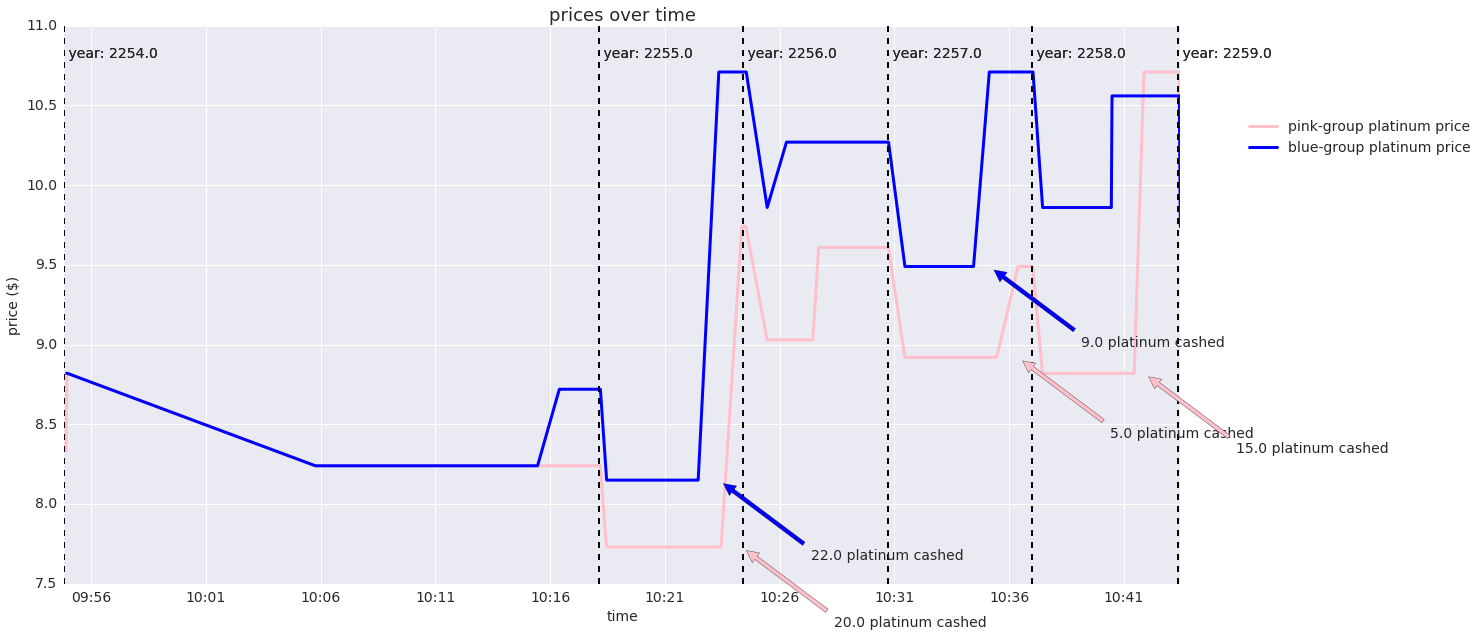

In [31]:
#sample code to run this function; need to make a figure, and add a legend once all lines have been added
fig, ax = plt.subplots(figsize=(20, 10))
plotPriceChanges(3.0,'platinum',myGame,myData) 
plotPriceChanges(4.0,'platinum',myGame,myData)
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.8))

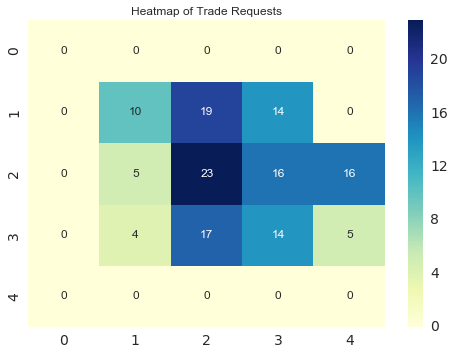

In [32]:
#make a heat map of trade requests by zones

#make a df with only trade requests
df = myData[myData['key']=='TradeRequestSent']

#get a list of all the zones where trades occurred
tradeZones = df['zone']

#load in a file that maps zone codes onto x-y coordinates
mapping = pd.read_csv('zonemapping.csv')
mapping = mapping.set_index('code')

#make a series for number of trades in a zone
count = Series(np.zeros(len(mapping)), index=mapping.index)

#total up the number of requests in each zone and store in the count series
for i in range(len(df)):
    curZone = df.iloc[i]['zone']
    count[curZone] = count[curZone]+1

#add count series to the dataframe
mapping['count']=count

#now use the count values to make a heat map

#first, make a 5 by 5 array and fill it with the count values
heatMapVals = np.zeros([5,5])

for code in list(mapping.index):
    xVal = mapping.loc[code]['x']
    yVal = mapping.loc[code]['y']
    heatMapVals[xVal][yVal]=int(mapping.loc[code]['count'])

#then use seaborn (sns) to make an annotated heat map
#in this data, all the trades happened in one zone only
ax = sns.heatmap(heatMapVals, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Trade Requests')

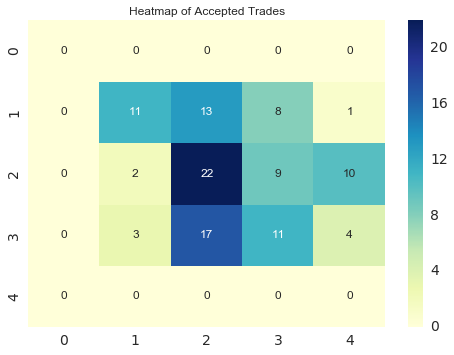

In [33]:
#now make a heatmap of accepted trades
#make a heat map of trade requests by zones

#make a df with only trade requests
df = myData[(myData['key']=='TradeRequestResponded') & (myData['response']==1)]

#get a list of all the zones where trades occurred
tradeZones = df['zone']

#load in a file that maps zone codes onto x-y coordinates
mapping = pd.read_csv('zonemapping.csv')
mapping = mapping.set_index('code')

#make a series for number of trades in a zone
count = Series(np.zeros(len(mapping)), index=mapping.index)

#total up the number of requests in each zone and store in the count series
for i in range(len(df)):
    curZone = df.iloc[i]['zone']
    count[curZone] = int(count[curZone]+1)

#add count series to the dataframe
mapping['count']=count

#now use the count values to make a heat map

#first, make a 5 by 5 array and fill it with the count values
heatMapVals = np.zeros([5,5])

for code in list(mapping.index):
    #print code
    xVal = mapping.loc[code]['x']
    yVal = mapping.loc[code]['y']
    heatMapVals[xVal][yVal]=int(mapping.loc[code]['count'])

#then use seaborn (sns) to make an annotated heat map
#in this data, all the trades happened in one zone only
ax = sns.heatmap(heatMapVals, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Accepted Trades')

In [34]:
#make a network analysis graph

#first grab data from a specific game, only trade responses that were completed
myKey = 'TradeRequestResponded'

isGame = myData['gameCode'] == myGame
isKey = myData['key'] == myKey
isResponse = myData['response'] == 1

df = myData[isKey & isGame & isResponse]

In [35]:
#make list of all the groups
trades = []

#make a dataframe with all the possible pairings, and nTrades = 0 for each pair
cols = ('g1','g2','nTrades')
nGroups = len(groups)

#calculates the number of possible pairings between nGroups
nPairs = math.factorial(nGroups)/((math.factorial(nGroups-2))*math.factorial(2))

#makes a trades data frame with length of nPairs
indices =  range(nPairs)
trades = pd.DataFrame(index=indices,columns=cols)

#initialize all the values of the data frame, filling in the combos of pairs and setting nTrades=0
#here, you could change from group # to group name by using the group dict to look it up
k=0
for i in range(len(groups)):
    #print 'i: ' +str(i)
    for j in range(i+1, len(groups)):
        #print 'j: '+str(j)
        trades.iloc[k]['g1']=groups[i]
        trades.iloc[k]['g2']=groups[j]
        trades.iloc[k]['nTrades']=0
        #print k
        k=k+1   
    

In [38]:
#loop through all the completed trades and determine who traded with who, and how often
for i in range(len(df)):
    reqGroup = df.iloc[i]['requesterGroup']
    recvGroup = df.iloc[i]['recipientGroup']
    
    #now increase the value for the trades array for this combo
    #find row where 1st col = reqGroup AND 2nd col = recvGroup or vice versa
    #if condition is met, increment nTrades and exit the interior loop
    for k in range(len(trades)):
        if int(trades.iloc[k]['g1'])==reqGroup and int(trades.iloc[k]['g2'])==recvGroup:
            trades.iloc[k]['nTrades'] = trades.iloc[k]['nTrades'] + 1
            break
        if int(trades.iloc[k]['g1'])==recvGroup and int(trades.iloc[k]['g2'])==reqGroup:
            trades.iloc[k]['nTrades'] = trades.iloc[k]['nTrades'] + 1
            break

#initialize a network group
G=nx.Graph()

#use trades df to make a network graph
for i in range(len(trades)):
    G.add_edge(groupDict[trades.iloc[i]['g1']],groupDict[trades.iloc[i]['g2']],weight=trades.iloc[i]['nTrades'])
    #use next line instead if you want graph labeled by group ID number rather than group name
    #G.add_edge(trades.iloc[i]['g1'],trades.iloc[i]['g2'],weight=trades.iloc[i]['nTrades'])

In [39]:
G.nodes()

['red-group',
 'blue-group',
 'turquoise-group',
 'orange-group',
 'pink-group',
 'white-group']

In [40]:
fixed_positions = {
    'orange-group':(0,10),
    'white-group':(0,0),
    'blue-group':(10,0),
    'pink-group':(10,10),
    'turquoise-group':(15,10),
    'red-group':(0,15)
}

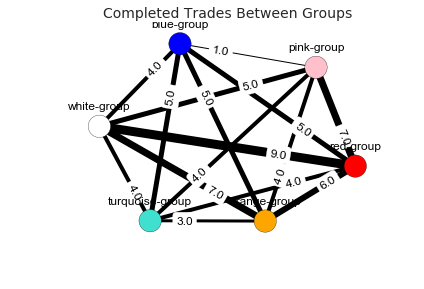

In [50]:
# labels
allEdges = [(u,v) for (u,v,d) in G.edges(data=True)]
allWidths = [((d)['weight'])*.5 for (u,v,d) in G.edges(data=True)] #sets widths equal to the weight (nTrades) for each edge

#the following code makes a network plot; more trades are represented as thicker lines between nodes
fixed_nodes = fixed_positions.keys()
#pos = nx.spring_layout(G,pos=fixed_positions, fixed = fixed_nodes)
pos = nx.spring_layout(G,k=6,iterations=20) # k varies from 0-1; bigger value for k means more space beween nodes

#sets colors of the nodes based on the group names
#if you leave out node_color argument, default node color is red
colorVals = list()
for node in G.nodes():
    colorVals.append(node.replace("-group", ""))
nx.draw_networkx_nodes(G,pos,node_size=500,node_color=colorVals)

# edges
nx.draw_networkx_edges(G,pos,edgelist=allEdges,width=allWidths)

# pos_higher is a dict of label positions that have been shifted in the y-direction by y_off
pos_higher = {}
y_off = 0.1  # offset on the y axis

for k, v in pos.items():
    pos_higher[k] = (v[0], v[1]+y_off)

    
#nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif') #this line centers the labels on the nodes
nx.draw_networkx_labels(G,pos_higher,font_size=12,font_family='sans-serif') #this positions the labels slightly above the nodes

#make edge labels, skipping those edges with 0 connections
edgeLabels = dict()
for i in range(len(allEdges)):
    if allWidths[i] != 0:
        edgeLabels[allEdges[i]]=allWidths[i]
        
#add labels, and place the label on the edge using label_pos, if label_pos=.5 then label is centered
nx.draw_networkx_edge_labels(G,pos, edgeLabels, font_size=12,label_pos=0.7)

plt.axis('off')
# plt.savefig("weighted_graph_feb1.png") # save as png
plt.tight_layout()
plt.title('Completed Trades Between Groups',size=14)
plt.show() # display